# FINAL Project

## 1. The company

## WeissBeerger

WeissBeerger, an Israeli start-up based in Tel-Aviv, develops IoT analytics tools that include sensors in the beer taps, refrigerators and other important points in the supply chain to provide bar and restaurant owners important beverage analytics.
Nowadays they mostly aim to analyze data based on table orders rather than IoT, mostly due to the availability of data.

## 2. The Data

The data we received from the company consists of table orders from restaurants all over Canada.
Initially the data contained over [ ] tables, and bacause of the massive amount of data, we decided to initally focus on Toronto, which sonsits of [ ]  total table orders.

A single table order consists of a unique order_id, along with the item titles and numeric features that come along with the items ordered at a table.

Example Table

In [2]:
import pandas as pd
data = pd.read_csv("../data/original_data.csv")

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
data[data.order_id == 650818052]

,city,bar_id,order_id,order_time,order_item_id,title,category_id,beer_brand_id,beer_serving_type_id,beer_volume,item_qty,sales_before_tax,sales_inc_tax,guest_count,waiter_id,country,country_id,state,state_id,timezone,bar_type_id,status,last_status,is_bulk,bar_type,data_availability_status_id
1574737,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805204,Pint Coors Light,1.0,280,2,0.591,1.0,5.97,6.746852,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574738,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805202,Chicken Fingers SAUCE,2.0,0,0,0.000,1.0,1.00,1.130126,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574739,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805201,Chicken Fingers,2.0,0,0,0.000,1.0,10.00,11.301259,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574740,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805205,Pop,4.0,0,0,0.000,1.0,2.00,2.260252,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574741,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805203,+add Gravy,2.0,0,0,0.000,1.0,1.00,1.130126,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1
1574742,Toronto,23193,650818052,2019-07-19 13:08:06.000,65081805200,Chicken Stirfry TERIYAKI,2.0,0,0,0.000,1.0,11.00,12.431385,0,2011.0,Canada,195,Ontario,49,America/Toronto,1,12,0,0,Bar/Pub,1


## Features present in the tables

- bar_id
- order_id
- order_time - open time for table
- order_time_closed - close time for table
- order_item_time
- order_item_id
- item_qty - quantity of that exact item in order
- sales_before_tax
- sales_inc_tax
- guest_count - total number of guests in table
- title - name of dish / beverage
- category_id - out of 6 possible categories
- beer_brand_id - when the item is a beer
- beer_serving_type - out of 6 possible categories
- beer_volume - when the item is a beer

## 3.  Goal for the project

## Goal: Be able to predict the type of Occasion that appears at a table, given the table order
### input: Aggregated table of all item rows (as shown above)
### output: Type of Occasion

What are Occasions?

Through collaborations with the company representatives, we were given initial occasions to work with, and allowed to change them as we saw fit.

Original Occasions:
	- Male social - occasion socializing with males only
	- Meal Occasion - key activity meal
		○ Possible to divide into a lot
		○ Meal formal
		○ Meal aformal
		○ Hungry/munchies
	- Party - a lively occasion where key activity is party
	- Mix-group social
		○ Date
		○ Happy hour
	- Relax together - doing a relax activity
    - Relax alone!

#  Annotations Task

Given these goals, our first step was to create a small annotation task for ourselves, in order to be able to understand the data and the task that's required of us.

## Intuition - Guest Count

We noticed that a major feature for predicting the occasion would have to be the guest count. Usually the number of people that are present at a table, can tell us what type of occasion is happening, or at least give us a hint.

Because of this - we take a closer look at the feature `guest count`.

### Analyzing the data and annotation guest count

When looking closely at the data, we noticed that a lot of the times the given Guest Count feature in a given table was not beleivable.

We decided to annotate multiple tables for Guest Count, and see if its even a feasible task.

Take a look at the following tables

In [20]:
data[data["order_id"] == 648222217]

,city,bar_id,order_id,order_time,order_item_id,title,category_id,beer_brand_id,beer_serving_type_id,beer_volume,item_qty,sales_before_tax,sales_inc_tax,guest_count,waiter_id,country,country_id,state,state_id,timezone,bar_type_id,status,last_status,is_bulk,bar_type,data_availability_status_id
156005,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221700,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156006,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221706,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156007,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221705,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156008,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221707,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156009,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221708,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156010,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221704,WINGS.5PC,2.0,0,0,0.000,1.0,10.47,11.832703,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156011,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221701,CORONA BTL,1.0,128,1,0.355,1.0,6.25,7.063457,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156012,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221703,WINGS,2.0,0,0,0.000,1.0,0.00,0.000000,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1
156013,Toronto,1177,648222217,2019-07-15 18:26:00.000,64822221702,Add.Fries^,2.0,0,0,0.000,1.0,2.97,3.356555,1,788.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1


How many people are sitting at the table?

Notice that the feature "Guest Count" says there is 1 person sitting at the table. 

Even between ourselves, our guest count labels ranged from 3people to 6 people.

In [21]:
data[data["order_id"] == 649560864]

,city,bar_id,order_id,order_time,order_item_id,title,category_id,beer_brand_id,beer_serving_type_id,beer_volume,item_qty,sales_before_tax,sales_inc_tax,guest_count,waiter_id,country,country_id,state,state_id,timezone,bar_type_id,status,last_status,is_bulk,bar_type,data_availability_status_id
1372306,Toronto,1279,649560864,2019-07-17 16:32:00.000,64956086400,BEACHED,3.0,0,0,0.0,1.0,0.0,0.0,0,65.0,Canada,195,Ontario,49,America/Toronto,10,11,0,0,Casual Dining,1


Or for example this table says the guest count is 0.

### In general, we found it to be a very hard task to predict the guest count, based on the data available to us alone. At the time, we were only allowed to have timestamps of the whole order, and not of each item.

## Conclusion for the annotation task

### After relating to the company the difficulty and necessity of guest count, and the representatives informing us that it is a known and difficult problem that they desperately need to solve, we decided to divide our work into two separate goals. This simply doesnt supply enough signal to correctly annotate the guest count (GC)

### Goal A 
#### Predict Occasions given data "trustworthy", meaning we assume we have true GC number and based on that we would predict the occasion.  we will filter out the data that isnt trustworth to contain only believable bars with "correct guest count". We explain further under data Processing what believable bars are.

### Goal B
#### Implement a guest count model given the above described data as labeled data.


This made our work much easier to handle, and made it so that we focued each task on a closed environment, rather than have a lot of noise in the original data and a vague direction.

## 4. Data Processing

We created the following three processing steps to clean and filter our data, and all of our models and data are assumed to have gone through this process.

## 4.1 Quality Bars

Since we wanted to count no the guest ocunt feature in the occasion model, we decided to filter out bars that are untrustworthy, meaning bars that exhibited unusual bahavior.

* We looked at the guest count distribution per bar_id.

We started with more than 700 bars, and eventaully after filtering bars we ended up with 35 trustworthy bars.
(~30k table orders)

Our filtering choices for removing bars:
    - (rule 1) Max guest count of 1 or 0
    - (rule 2) Any bars with s.t.d (standard deviation) of > 1.5

We chose these rules after looking at the distribution of bars that seemed believable in their reporting, for example the following bar contains a believable distribution:
(Also based on what the company told us, that about 30% of the data contained guest counts of 1)


Text(0.5, 1.0, 'Guest Count distribution for a Trustworthy Bar')

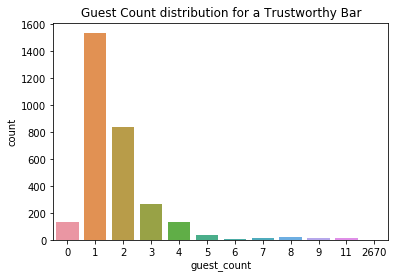

In [5]:
import matplotlib as plt
import seaborn as sns
sns.countplot(x="guest_count", data=data[data.bar_id == 11719]).set_title("Guest Count distribution for a Trustworthy Bar")


## 4.1 Data Cleaning

In data cleaning we removed the follwing two things:
    - (1) Nan tables
    - (2) Titles that were not informative

(1) is trivial, since we have a lot of data, we removed all tables that contained some Nan values. This occurred for 40k of the tables in only two features, the category_id of the item, and the beer_volume.
we decided to remove them.

(2) We removed all titles that were not informative for actual meals or drinks, such as sauces, side dishes, cancellations, etc.

Example for some of the textual filtering we did:

In [ ]:
    if "xtra" in title:
        return False
    if "sub" in title and price == 0:
        sub.add(title)
        return False
    elif "add" in title:
        return False
    elif "sauce" in title:
        for t in foods_w_sauce: 
            if t in title: return True
        for t in remove_w_sauce:
            if t in title: return False
        sauces.add(title)
        return False
    elif "no " in title:
        return False
    elif "no." in title:
        return False
    elif "-no " in title:
        return False
    elif "side " in title:
        return False

# TODO: show a graph which exhibit the different distribution between all the bars and the picked out bars

## 4.2 Feature Engineering

### This step proved to be the majority of our work, deciding on important features that eventually we'd want to use, and calculating informative numerical statistics.

The following features were added by us, after careful data evaluation:

- **total_orders_category_id_X** - we sum all the category ids in each item of the total order, and add 6 separate columns for each one, items of 0 cost are not counted (X = 1.0 ... 6.0) [6]
- **total_orders** - total number of items in an order, items of category 5 and items of 0 cost are not counted [1]
- **order_day_of_week** - "Friday", "Monday", etc [1]
- **is_weekend** - is the order day landed on a weekend (friday - sunday) [1]
- **sharable** - is the item "title" a food that is a typical "sharing" food? (pizza, fries, wings, etc) [1]
- **kids_meal** - is the item a "kid" item [1]
- **birthday** - is there a comment in the order about a "birthday" [1]
- **order(_close)_hour/minute** - the order(_close)_time hour & minute for start & close times [4]
- **order_item_hour/minute** - the order_item_time hour & minute [2]
- **period_of_day** - what part of the day did the order occur in (breakfast, lunch, etc) [1]
- **dwell_time** - the total time (in hours) the table order was open for [1]
- **meal_step** - the step in which the current item was ordered in. If the item was ordered after more than 4 minutes than the previous item, then the item is considered to be in the next numeric step. (1 - n steps, in increments of 1) [1]
- **meal_flow_step** - the "flow" step in which the current item was ordered in. The same as meal_step, except the increments are (time between the previous order / 4 minutes) - this means we consider "flow_steps" to be four minutes long. Each flow step is added the total flow steps up to that point [1]
- **total_flow_steps** - the total flow steps in that order [1]
- **meal_flow_last_to_close** - the number of flow steps occurred, between the last item ordered, and till the table order was closed [1]
- **total_meal_steps** - the total number of meal steps in that order [1]
- **first_to_second_order** - the time passed between the 2 first orders [1]
- **avg_time_between_steps** - average time between item orders in that order [1]
- **sit_to_order** - the time passed until the first item order [1]
- **max_items_per_step** - the highest count of items ordered in a step [1]
- **total_large_meals** - number of large meals in that order, items of 0 cost are not counted [1]
- **total_small_meals** - number of small meals in that order, items of 0 cost are not counted [1]
- **total_large_sharable_meals** - number of large sharable meals in that order, items of 0 cost are not counted [1]
- **total_small_sharable_meals** - number of small sharable meals in that order, items of 0 cost are not counted [1]

# 6. Models

# 6.1 Guest Count Model

# 6.2 Occasions Heuristics Model

###### we conclude that since we dont have labeled data regarding the occasions, we would need to create an heuristic model to predict the occasion type. since occasion types varies with respect to the GC we decided to split the tables into bins of GC. we split the data GC to four bins:
* GC = 1
* GC = 2
* GC = 3-5
* GC = 6 or more

Each team member looked deeply into a particular bin, the bin owner learned through annotations of orders, what kind of occasions exist in this bin. Eventually the bin owner wrote down a set of rules to determine given what kind of event goes on at the table, given a table order . 



###### To maintain intergrity of the model, each bin owner annotated a dev set and a test set. (50 tables dev and 25 test)
###### the heuristic was based on tables from the dev set, and tested on the test set. 
###### our average accuracy rate reaches 90.5% 

# 7. Insights and Discussions

##### there are dozens of data analysis that can be done on this data, we have picked some to share with you

###### Underneath you may see the dwell time distribution for the drinking event per bin, this is an impressive insight since you can clearly see that the people at the table the more time they spend at the bar

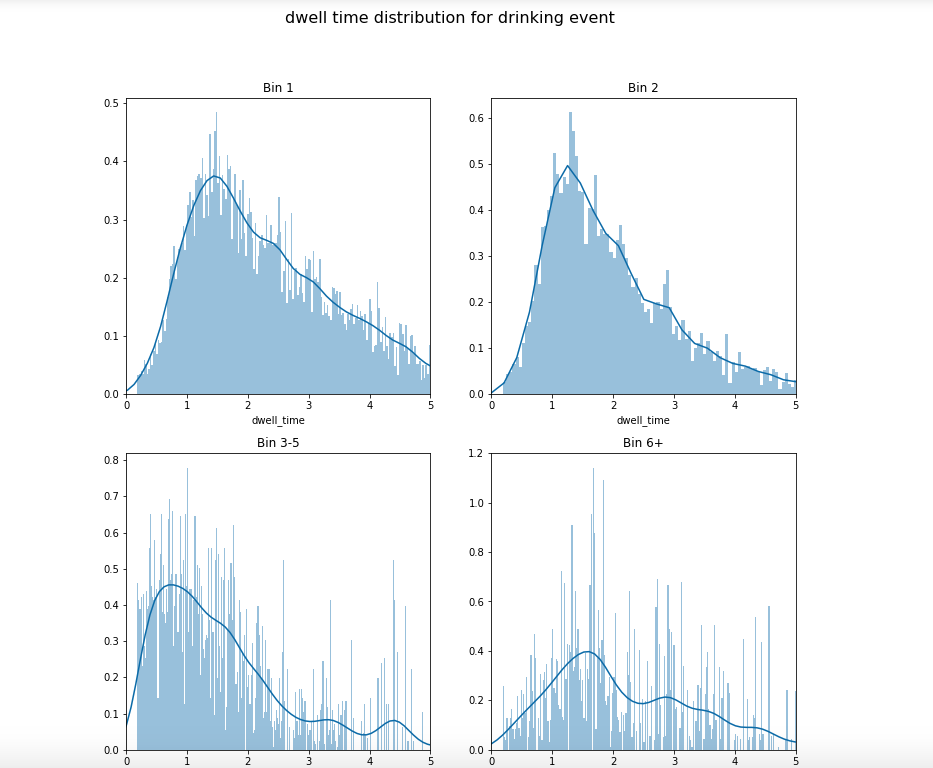

In [16]:
from IPython.display import Image
Image("image1.png")